In [1]:
import numpy as np
import matplotlib.pylab as plt
import os
import csv
import tensorflow as tf
import tensorflow.contrib.slim as slim
from graphs import FFN_dae_lh_model

/lclhome/dli/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1.Load MNIST & Select Dataset 

Extracting ./MNIST/train-images-idx3-ubyte.gz
Extracting ./MNIST/train-labels-idx1-ubyte.gz
Extracting ./MNIST/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/t10k-labels-idx1-ubyte.gz
The number of training samples is 12873, including sample 1: 6742, sample 3: 6131
The number of testing samples is 2145, including digit 1: 1135, digit 3: 1010


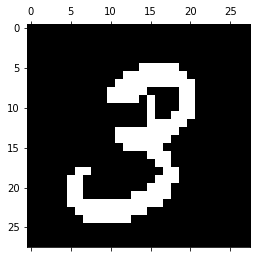

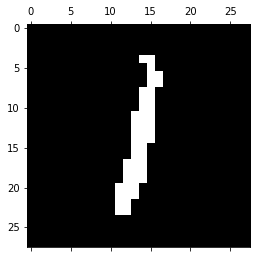

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data_dir = './MNIST'
mnist_input = input_data.read_data_sets(data_dir, one_hot = True)
#select two classes:digit '1' and '3'
dataset_images = np.vstack((mnist_input.train.images, mnist_input.validation.images, mnist_input.test.images))
dataset_labels = np.vstack((mnist_input.train.labels, mnist_input.validation.labels, mnist_input.test.labels))
is_digit_1, is_digit_3 = (dataset_labels[:, 1] == 1.), (dataset_labels[:, 3] == 1.)
selected_training = is_digit_1[:60000] + is_digit_3[:60000]
selected_test = is_digit_1[60000:] + is_digit_3[60000:]
selected = is_digit_1 + is_digit_3

#discretize the attributes, and round the pixel to be 0 or 1
training_x = np.round(dataset_images[:60000][selected_training], 0)
training_y = dataset_labels[:60000][selected_training][:, [1, 3]]
#discretize the attributes, and round the pixel to be 0 or 1
test_x = np.round(dataset_images[60000:][selected_test], 0)
test_y = dataset_labels[60000:][selected_test][:, [1, 3]]

#output some useful imformation
MSG = 'The number of training samples is {0}, including sample 1: {1}, sample 3: {2}' 
print MSG.format(training_x.shape[0], np.sum(is_digit_1[:60000]), np.sum(is_digit_3[:60000]))
MSG = 'The number of testing samples is {0}, including digit 1: {1}, digit 3: {2}' 
print MSG.format(test_x.shape[0], np.sum(is_digit_1[60000:]), np.sum(is_digit_3[60000:]))

for i in range(2):
    plt.matshow(training_x[i, :].reshape(28, 28), vmin = 0., vmax = 1., cmap = plt.cm.gray)
    plt.show()

# 2.Hyper-parameters

In [3]:
#solver
import utils
input_dims = training_x.shape[1]
hidden_dims =[32, 32]
output_dims =2
    
params = {
    'n_epoches':30,
    'batch_size':128,
    'learning_rate':0.001,
    'keep_prob': 0.6,
    'input_dim' : input_dims,
    'output_dim' : output_dims,
    'hidden_dims': hidden_dims,
    'adv_k' : 64,
    'K' : 32,
    'L' : 64
}
args = utils.ParamWrapper(params)

#bais
train_bais = np.array([[1., 1]], dtype = np.float32)
test_bais = np.array([[1., 1]], dtype = np.float32)

tf.reset_default_graph()
feed_forward_model = FFN_dae_lh_model(args)

In [4]:
#the probability of corrupting hashing codes
epsilon = 10.
sigma = epsilon/input_dims
mu = 0.0
def random_noises(batch_size):
    p = np.clip(np.random.randn()*sigma + mu, a_min= 0., a_max= 1.)
    return np.random.binomial(1, p, (batch_size, args.L, args.K))

def random_noises_vir(batch_size):
    return np.zeros((batch_size, args.L, args.K))

# 3.Training

In [5]:
#training
saver_dae = tf.train.Saver(feed_forward_model.share_vars)
model_dir = './MNIST/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_jid_dir = os.path.join(model_dir, "jid/")
if not os.path.exists(model_jid_dir):
    os.makedirs(model_jid_dir)
    
model_save_path = os.path.join(model_jid_dir, "jid.ckpt")
sess = tf.Session()
init = tf.global_variables_initializer()
_shuffle_idx = np.arange(0, training_x.shape[0])
np.random.shuffle(_shuffle_idx)
display_step = 100
print("Start DAE training...")
best_recon_loss = 5.
best_iteration = 0
with sess.as_default():
    sess.run(init)
    n_batches = training_x.shape[0] // args.batch_size
    avg_losses = []
    for epoch in range(args.n_epoches): #increaing the epochs could improve the resistance
        for mini_idx in range(n_batches):
            iterations = mini_idx + 1 + epoch * n_batches
            start_i = mini_idx * args.batch_size 
            end_i = start_i + args.batch_size 
            if end_i > training_x.shape[0]:
                end_i = training_x.shape[0]
            _feed_dict = {
                feed_forward_model.x: training_x[_shuffle_idx[start_i:end_i]],
                feed_forward_model.noises: random_noises(end_i - start_i),
                feed_forward_model.is_training: True
            }
            _, loss = sess.run([feed_forward_model.dae_optimizer, feed_forward_model.dae_loss], feed_dict = _feed_dict)
            
            if iterations % display_step == 0:
                MSG1 = "The iteation is {0}, with training loss {1:.3}"
                print(MSG1.format(iterations, loss))
                
                test_noise = random_noises_vir(test_x.shape[0])
                _feed_dict = {
                    feed_forward_model.x: test_x,
                    feed_forward_model.noises: test_noise,
                    feed_forward_model.is_training: False
                }
                loss2 = sess.run(feed_forward_model.dae_loss, feed_dict = _feed_dict)
                if loss2 < best_recon_loss:
                    best_recon_loss = loss2
                    best_iteration = iterations
                    saver_dae.save(sess, model_save_path)
                    print("the parameters of model saved at %s" % model_save_path)
                MSG2 = "\t the test loss is {0:.3}, with the best reconstruction loss is {1:.3} and acheved at {2}"
                print(MSG2.format(loss2, best_recon_loss, best_iteration))          

Start DAE training...
The iteation is 100, with training loss 0.216
the parameters of model saved at ./MNIST/model/jid/jid.ckpt
	 the test loss is 0.206, with the best reconstruction loss is 0.206 and acheved at 100
The iteation is 200, with training loss 0.201
the parameters of model saved at ./MNIST/model/jid/jid.ckpt
	 the test loss is 0.194, with the best reconstruction loss is 0.194 and acheved at 200
The iteation is 300, with training loss 0.192
the parameters of model saved at ./MNIST/model/jid/jid.ckpt
	 the test loss is 0.181, with the best reconstruction loss is 0.181 and acheved at 300
The iteation is 400, with training loss 0.183
the parameters of model saved at ./MNIST/model/jid/jid.ckpt
	 the test loss is 0.173, with the best reconstruction loss is 0.173 and acheved at 400
The iteation is 500, with training loss 0.177
the parameters of model saved at ./MNIST/model/jid/jid.ckpt
	 the test loss is 0.155, with the best reconstruction loss is 0.155 and acheved at 500
The itea

In [6]:
with sess.as_default():
    best_acc= 0.
    iterations = 0
    display = 100
    n_batches = training_x.shape[0] // args.batch_size
    for epoch in range(args.n_epoches):
        for mini_idx in range(n_batches):
            iterations = mini_idx + 1 + epoch * n_batches
            start_i = mini_idx * args.batch_size 
            end_i = start_i + args.batch_size 
            if end_i > training_x.shape[0]:
                end_i = training_x.shape[0]
            _feed_dict = {
                feed_forward_model.x: training_x[_shuffle_idx[start_i:end_i]],
                feed_forward_model.noises: random_noises_vir(end_i - start_i),
                feed_forward_model.y: training_y[_shuffle_idx[start_i:end_i]],
                feed_forward_model.bias: train_bais,
                feed_forward_model.is_training: True,
                feed_forward_model.is_adv_training: False
            }
            _, loss, acc = sess.run([feed_forward_model.update_clf, feed_forward_model.clf_loss, feed_forward_model.acc], feed_dict = _feed_dict)
            
            if iterations % display == 0:
                _feed_dict = {
                    feed_forward_model.x: test_x,
                    feed_forward_model.noises: random_noises_vir(test_x.shape[0]),
                    feed_forward_model.y: test_y,
                    feed_forward_model.bias: test_bais,
                    feed_forward_model.is_training: False,
                    feed_forward_model.is_adv_training: False
                }
                loss2, acc2 = sess.run([feed_forward_model.clf_loss, feed_forward_model.acc], feed_dict = _feed_dict)
                
                MSG1 = "The iteation is {0}, with training loss {1:.3} and batch accuracy {2:.4}"
                MSG2 = "\t the test loss is {0:.3} and test accuracy is {1:.5}"
                print MSG1.format(iterations, loss, acc)
                print MSG2.format(loss2, acc2)
                
               

The iteation is 100, with training loss 0.0371 and batch accuracy 0.9844
	 the test loss is 0.0254 and test accuracy is 0.99207
The iteation is 200, with training loss 0.0458 and batch accuracy 0.9844
	 the test loss is 0.0245 and test accuracy is 0.99207
The iteation is 300, with training loss 0.031 and batch accuracy 0.9844
	 the test loss is 0.0227 and test accuracy is 0.99161
The iteation is 400, with training loss 0.0139 and batch accuracy 1.0
	 the test loss is 0.0218 and test accuracy is 0.99207
The iteation is 500, with training loss 0.0279 and batch accuracy 0.9844
	 the test loss is 0.0229 and test accuracy is 0.99114
The iteation is 600, with training loss 0.0273 and batch accuracy 0.9844
	 the test loss is 0.0224 and test accuracy is 0.99114
The iteation is 700, with training loss 0.00856 and batch accuracy 1.0
	 the test loss is 0.0199 and test accuracy is 0.99301
The iteation is 800, with training loss 0.0268 and batch accuracy 0.9922
	 the test loss is 0.021 and test acc

# ================Test Adversarial Examples================

In [7]:
#load adversarial examples
save_dir = "./MNIST"

save_path1 = os.path.join(save_dir, 'clean.data')
save_path2 = os.path.join(save_dir, 'fgsm_10.data')
save_path3 = os.path.join(save_dir, 'fgsm_20.data')
save_path4 = os.path.join(save_dir, 'fgsm_50.data')
save_path5 = os.path.join(save_dir, 'fgsm_100.data')
save_path_label = os.path.join(save_dir, 'clean.label')

save_path1_opt = os.path.join(save_dir, 'opt_5.data')
save_path2_opt = os.path.join(save_dir, 'opt_10.data')
save_path3_opt = os.path.join(save_dir, 'opt_20.data')

samples = utils.readdata_np(save_path1)
labels =  utils.readdata_np(save_path_label)
adv_examples_fgm_10 =  utils.readdata_np(save_path2)
adv_examples_fgm_20 =  utils.readdata_np(save_path3)
adv_examples_fgm_50 =  utils.readdata_np(save_path4)
adv_examples_fgm_100 =  utils.readdata_np(save_path5)

adv_examples_opt_5 =  utils.readdata_np(save_path1_opt)
adv_examples_opt_10 =  utils.readdata_np(save_path2_opt)
adv_examples_opt_20 =  utils.readdata_np(save_path3_opt)

In [8]:
def evaluate_adv_sampels(sess, adv_samples, labels):
    _feed_dicts = {
        feed_forward_model.x: adv_samples,
        feed_forward_model.noises: random_noises_vir(adv_samples.shape[0]),
        feed_forward_model.y: labels,
        feed_forward_model.bias:test_bais,
        feed_forward_model.is_training: False,
        feed_forward_model.is_adv_training: False
    }
    return sess.run(feed_forward_model.acc, feed_dict = _feed_dicts)

In [9]:
acc_clean = evaluate_adv_sampels(sess, samples, labels)
acc_fgs_10 = evaluate_adv_sampels(sess, adv_examples_fgm_10, labels)
acc_fgs_20 = evaluate_adv_sampels(sess, adv_examples_fgm_20, labels)
acc_fgs_50 = evaluate_adv_sampels(sess, adv_examples_fgm_50, labels)
acc_fgs_100 = evaluate_adv_sampels(sess, adv_examples_fgm_100, labels)
acc_opt_5 = evaluate_adv_sampels(sess, adv_examples_opt_5, labels)
acc_opt_10 = evaluate_adv_sampels(sess, adv_examples_opt_10, labels)
acc_opt_20 = evaluate_adv_sampels(sess, adv_examples_opt_20, labels)
print("The accuracy on clean sampels is %.3f, vs that on adversarial exampels generated by fgm is %.3f, %.3f, %.3f, %.3f" \
      % (acc_clean, acc_fgs_10, acc_fgs_20, acc_fgs_50, acc_fgs_100))
print("The accuracy on adversarial examples generated by optimization method is %.3f, %.3f, %.3f" % \
      (acc_opt_5, acc_opt_10, acc_opt_20))

The accuracy on clean sampels is 1.000, vs that on adversarial exampels generated by fgm is 1.000, 1.000, 1.000, 0.970
The accuracy on adversarial examples generated by optimization method is 1.000, 1.000, 1.000
